# Plot EDGAR dataset
The dataset is from timestamp **2016-10-01 00:00:00** to **2016-12-31 23:00:00**  
**requests** represents the maximum number of requests received by the webserver within the given hour, with a resolution of 1s

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [8]:
def parse_datetime(x):
    # return pandas datetime
    return pd.to_datetime(x, format='%Y-%m-%d %H:%M:%S')

series = pd.read_csv(
    './Processed/EDGAR/access.csv', # filename
    header=None, # contains no header
    index_col=0, # set datetime column as index
    names=['datetime', 'requests'], # name the columns
    converters={'datetime': parse_datetime}, # custom datetime parser
    squeeze=True, # convert to Series
    dtype={'requests': np.float64} # https://git.io/vdbyk
)

--- HEAD ---
datetime
2016-10-01 00:00:00     628.0
2016-10-01 01:00:00     644.0
2016-10-01 02:00:00     477.0
2016-10-01 03:00:00     460.0
2016-10-01 04:00:00    5291.0
Name: requests, dtype: float64
--- TAIL ---
datetime
2016-12-31 19:00:00    567.0
2016-12-31 20:00:00    446.0
2016-12-31 21:00:00    556.0
2016-12-31 22:00:00    558.0
2016-12-31 23:00:00    263.0
Name: requests, dtype: float64


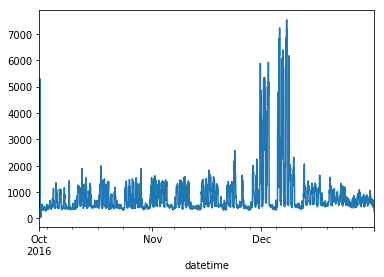

In [9]:
print('--- HEAD ---')
print(series.head())
print('--- TAIL ---')
print(series.tail())

series.plot();

# Naive forecast
The last observed value will occur in the next time interval

In [10]:
print(series[series.last_valid_index()])

263.0


# Autoregressive (AR)
It is a regression of the variable against itself.  
The model is represented as *AR(p)*, where the *AR* process depends on *p* past observations.  

We will be computing *AR(1)*, which is equivalent to *ARIMA(1,0,0)* and *ARMA(1,0)*.

/home/gvkalra/Documents/Ensemble/venv/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


[ 356.49024437  435.10592737  501.21363365  556.80341755  603.54871016
  642.85669497  675.91066862  703.70566191  727.07839343  746.73245749
  763.25950457  777.15705188  788.84346025  798.67052811  806.93408178
  813.88288077  819.72610625  824.6396581   828.77145     832.24586216
  835.16748555  837.62427043  839.69017391  841.42738633  842.88820335
  844.11660027  845.14955578  846.01816515  846.74857633  847.36277703
  847.87925666  848.31356293  848.67876985  848.98587132  849.24411208
  849.46126601  849.64387013  849.79742143  849.92654228  850.03511964
  850.12642203  850.20319796  850.26775862  850.3220475   850.36769886
  850.40608696  850.43836741  850.46551195]


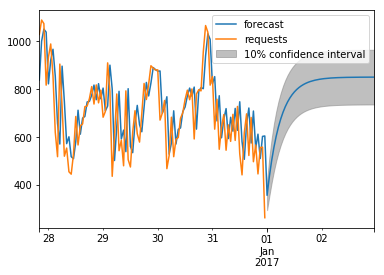

In [11]:
from statsmodels.tsa.arima_model import ARMA

ar = ARMA(series, order=(1,0)) # (p,q) = (1,0)
ar_fit = ar.fit()

print(ar_fit.forecast(48)[0])
ar_fit.plot_predict(start=series.tail(100).index[0],
                    end=series.last_valid_index() + pd.Timedelta(hours=48),
                    alpha=0.90);

# Autoregressive Moving Averages (ARMA)
The model is represented as *ARMA(p,q)*,  
where the *AR* process depends on *p* past observations and *MA* process depends on *q* past observations.  

We will be computing *ARMA(1,1)*, which is equivalent to *ARIMA(1,0,1)*.

[ 393.44559318  435.87569864  474.36059561  509.26711488  540.92797886
  569.64497294  595.69182214  619.31680013  640.74509576  660.18095953
  677.80965043  693.79920185  708.30202319  721.45635262  733.38757473
  744.2094157   754.02502728  762.92797004  771.00310517  778.32740332
  784.97067834  790.99625268  796.46156098  801.41869753  805.91491283
  809.99306396  813.6920231   817.04704802  820.09011819  822.85023958
  825.35372116  827.62442565  829.68399696  831.55206655  833.24644051
  834.78326929  836.17720166  837.44152431  838.58828853  839.62842507
  840.57184831  841.42755078  842.20368888  842.90766061  843.5461761
  844.12532156  844.65061729  845.12707031]


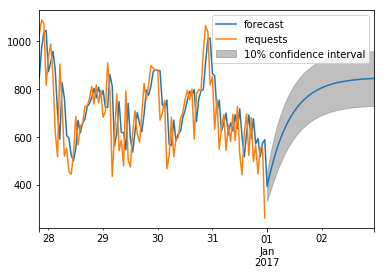

In [12]:
from statsmodels.tsa.arima_model import ARMA

arma = ARMA(series, order=(1,1)) # (p,q) = (1,1)
arma_fit = arma.fit()

print(arma_fit.forecast(48)[0])
arma_fit.plot_predict(start=series.tail(100).index[0],
                      end=series.last_valid_index() + pd.Timedelta(hours=48),
                      alpha=0.90);

# Autoregressive Integrated Moving Averages (ARIMA)
The model is represented as *ARIMA(p,d,q)*,  
where the *AR* process depends on *p* past observations, *MA* process depends on *q* past observations,  
and *d* represents the order of integration (to make time-series stationary).  

We will be computing R's equivalent of *auto.ARIMA()*.

### Check for stationarity
- **p-value** should be < 0.05
- **Test Statistic** should be < **Critical Value (5%)**

[Read More](https://datascience.ibm.com/exchange/public/entry/view/815137c868b916821dec777bdc23013c)

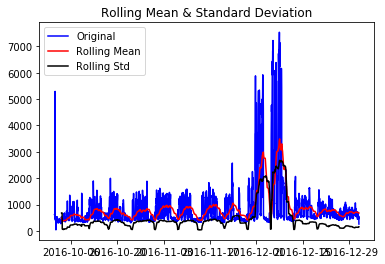

Test Statistic                   -4.450630
p-value                           0.000241
#Lags Used                       27.000000
Number of Observations Used    2180.000000
Critical Value (10%)             -2.567476
Critical Value (5%)              -2.862867
Critical Value (1%)              -3.433353
dtype: float64


In [13]:
from statsmodels.tsa.stattools import adfuller

# Rolling statistics
rolmean = series.rolling(window=52, center=False).mean()
rolstd = series.rolling(window=52, center=False).std()

orig = plt.plot(series, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

# Dickey-Fuller test
dftest = adfuller(series, autolag='AIC')
dfoutput = pd.Series(dftest[0:4],
                     index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)

[ 402.37512656  419.46933645  418.12144325  429.75100234  477.49911042
  475.22325729  482.56639161  505.66512873  505.62450917  500.95396085
  505.49164706  498.70568713  485.8434306   477.82273553  465.83811826
  450.13877894  437.89481133  426.05043409  413.5263804   404.32489048
  397.69942434  392.3840704   390.15614434  390.85982647  393.30953958
  397.92133611  404.50200387  412.02737005  420.25490176  428.90155814
  437.19980967  444.76497781  451.37998481  456.62283171  460.27520104
  462.32256837  462.70317019  461.46582334  458.81679137  454.96635786
  450.16585273  444.74559537  439.02709956  433.3135922   427.91212752
  423.08875047  419.05105235  415.96240946]


/home/gvkalra/Documents/Ensemble/venv/lib/python3.5/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


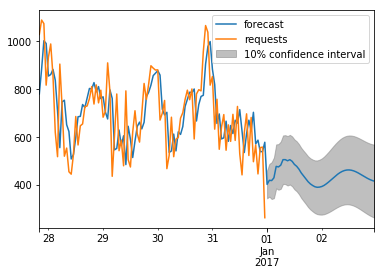

In [28]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings

# Select p and q
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    arma_params = arma_order_select_ic(series, fit_kw=dict(method='css'))

p = arma_params.bic_min_order[0]
q = arma_params.bic_min_order[1]

arima = ARIMA(series, order=(p,0,q))
arima_fit = arima.fit()

print(arima_fit.forecast(48)[0])
arima_fit.plot_predict(start=series.tail(100).index[0],
                       end=series.last_valid_index() + pd.Timedelta(hours=48),
                       alpha=0.90);

# Forecasting using R

## Installing forecast

In [52]:
import rpy2.robjects.packages as rpackages
import warnings

# select mirror
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    utils.install_packages('forecast')

## Setup forecast

In [70]:
import rpy2.robjects as robjects

forecast = rpackages.importr('forecast')
ts = robjects.r('ts')

robjects.pandas2ri.activate()
rdata = ts(series.values)

## AR (1)

In [83]:
ar_fit = forecast.Arima(rdata, robjects.FloatVector((1,0,0)))
ar_forecast = forecast.forecast(ar_fit, h=24)
print(np.asarray(ar_forecast[3]))

[ 356.79235592  435.66164819  501.98224759  557.75074478  604.64605796
  644.07997691  677.23966512  705.12339952  728.57062373  748.28721962
  764.86675798  778.80836809  790.53176401  800.38988016  808.67949648
  815.65017299  821.51176286  826.44073004  830.58546177  834.07073575
  837.00147664  839.46591479  841.53824244  843.28084729]


## ARMA (1,1)

In [84]:
arma_fit = forecast.Arima(rdata, robjects.FloatVector((1,0,1)))
arma_forecast = forecast.forecast(arma_fit, h=24)
print(np.asarray(arma_forecast[3]))

[ 393.70041573  436.25883048  474.86942353  509.89840439  541.67801208
  570.50966633  596.66682645  620.397585    641.92702087  661.45933409
  679.17978258  695.25643933  709.84178643  723.07416138  735.07906916
  745.97037259  755.85137232  764.81578657  772.94864002  780.32707028
  787.02105946  793.09409798  798.60378672  803.60238339]


## ARIMA

In [100]:
arima_fit = forecast.auto_arima(rdata)
arima_forecast = forecast.forecast(arima_fit, h=24)
print(np.asarray(arima_forecast[3]))

[ 404.66753465  401.07852956  409.45822295  424.99008413  464.32232937
  457.6168783   468.99497681  491.70355646  483.1904633   480.42213167
  488.71773669  474.76915179  461.9207408   459.50717661  443.249475
  426.79330902  420.50498158  407.12786224  393.76707474  389.94371703
  383.59028828  377.49450582  379.4691979   381.16150402]


## ETS

In [99]:
ets_fit = forecast.ets(rdata)
ets_forecast = forecast.forecast(ets_fit, h=24)
print(np.asarray(ets_forecast[1]))

[ 341.13018084  341.08762347  341.0461922   341.00585723  340.96658956
  340.92836093  340.89114386  340.85491158  340.81963804  340.78529785
  340.75186634  340.71931944  340.68763376  340.65678651  340.62675549
  340.59751912  340.56905637  340.54134676  340.51437036  340.48810778
  340.46254013  340.43764901  340.41341654  340.38982527]
